MAE модели: 0.0821


/var/folders/wf/yt2jwwp97hg89ms8kj37bvt40000gq/T/ipykernel_1929/2346401190.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Прогноз изменения', y='Название базы данных', data=top_20, palette=colors)


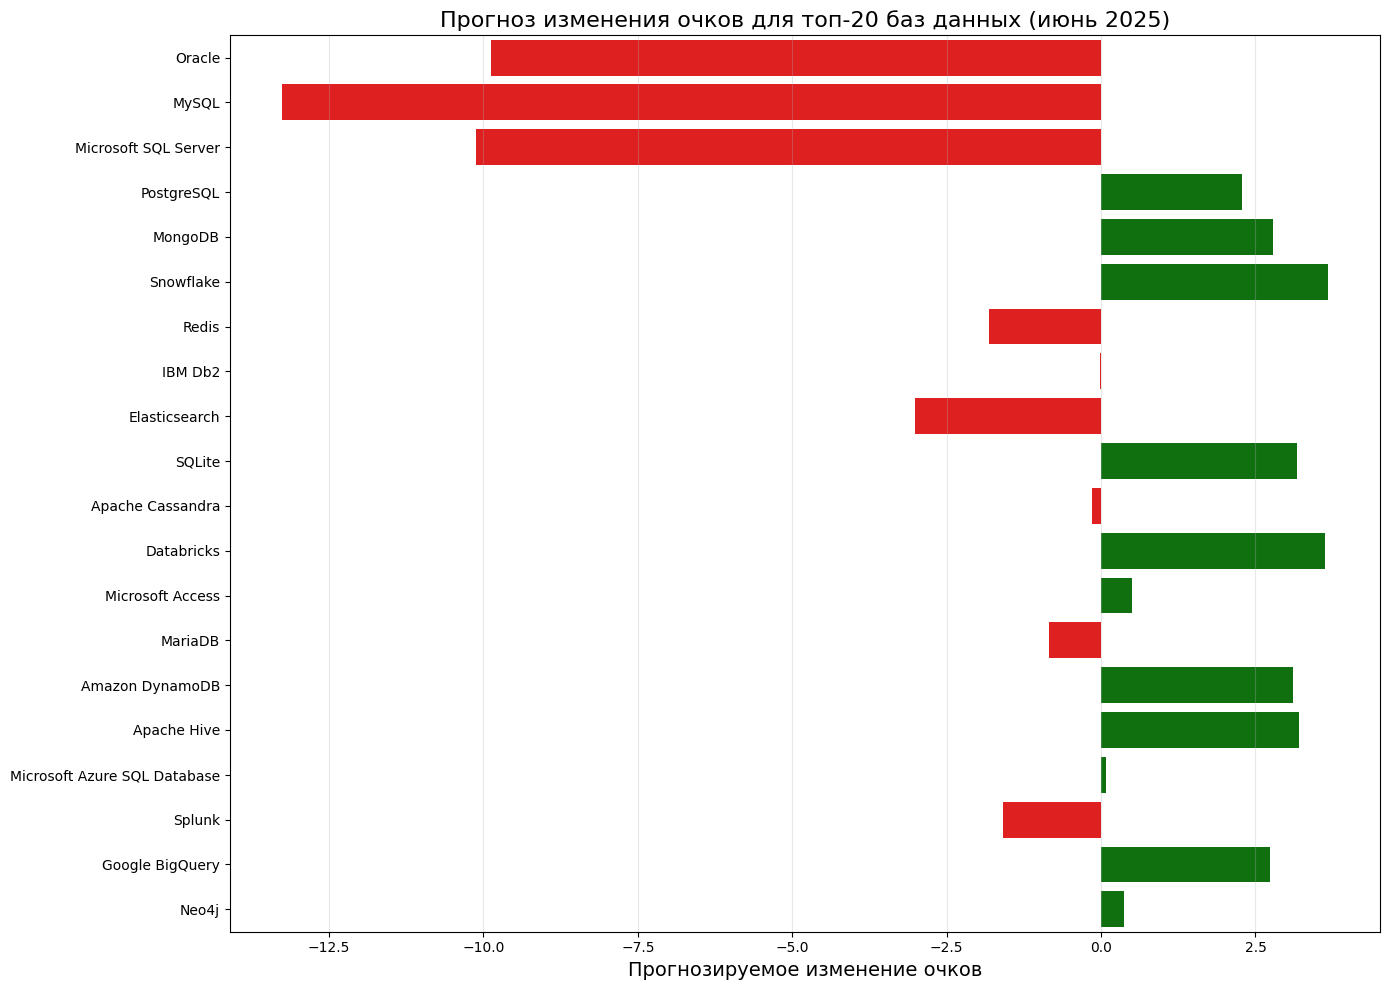

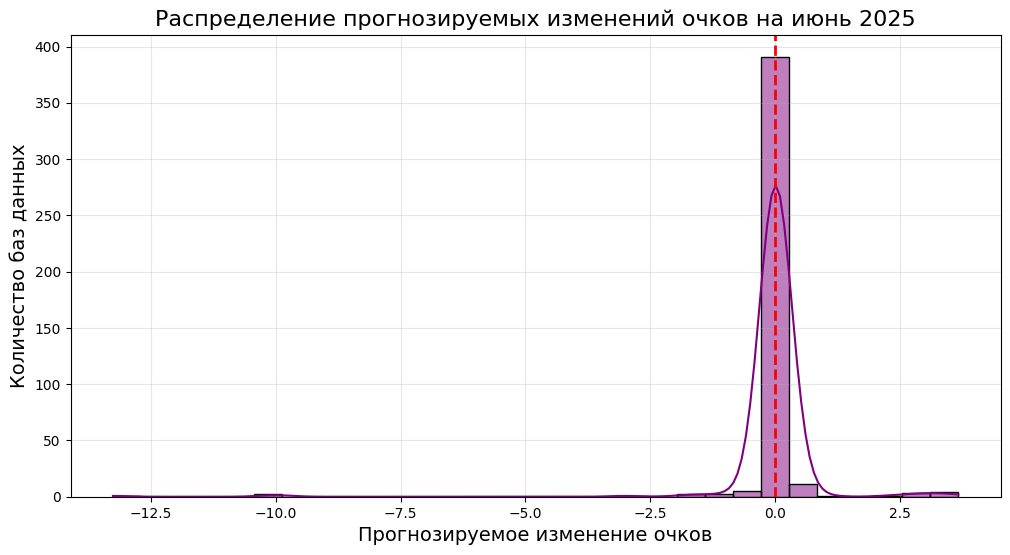

Финальная таблица сохранена в 'top_50_databases_june_forecast.csv'
Модель для прогнозирования сохранена в 'db_score_change_predictor.joblib'

Топ-50 баз данных с прогнозом на июнь 2025:
 Позиция в рейтинге (май 2025) Название базы данных                                               Тип базы данных Очки (май 2025) Изменение очков (месяц) Изменение очков (год) Прогноз изменения очков (июнь 2025)
                             1               Oracle                                                    Relational         1226.57                   -4.49                 -9.72                               -9.88
                             2                MySQL                                                    Relational          964.98                  -22.12               -118.76                              -13.26
                             3 Microsoft SQL Server                                                    Relational          774.89                  -10.12                -49.41   

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Загрузка данных
ranking_df = pd.read_csv('db_ranking.csv')
scores_df = pd.read_csv('db_scores.csv')

# Объединение данных
merged_df = pd.merge(ranking_df, scores_df, on='DBMS', how='inner')

# Очистка названий DBMS
merged_df['DBMS'] = merged_df['DBMS'].str.replace('Detailed vendor-provided information available', '').str.strip()

# Функция для преобразования данных
def convert_value(value):
    if isinstance(value, str):
        # Удаляем специальные символы и пробелы
        value = value.replace('±', '').replace('+', '').strip()
        # Обработка пустых значений и специальных случаев
        if value in ['', 'nan', 'NaN', 'NA', 'None']:
            return np.nan
        try:
            return float(value)
        except ValueError:
            return np.nan
    return value

# Преобразование всех числовых столбцов
numeric_cols = ['May 2025 Rank', 'Apr 2025 Rank', 'May 2024 Rank', 
               'May 2025 Score', 'Apr 2025 Score Change', 'May 2024 Score Change']

for col in numeric_cols:
    merged_df[col] = merged_df[col].apply(convert_value)
    
    # Замена пропущенных значений
    if col.endswith('Rank'):
        max_val = merged_df[col].max()
        if pd.isna(max_val):
            max_val = 0
        merged_df[col] = merged_df[col].fillna(max_val + 1000).astype(int)
    else:
        median_val = merged_df[col].median()
        merged_df[col] = merged_df[col].fillna(median_val)

# Подготовка данных для прогнозирования изменения очков на июнь 2025
# Разделение Database Model на отдельные признаки
models = ['Relational', 'Document', 'Key-value', 'Wide column', 'Time Series', 
          'Graph', 'Search engine', 'Spatial', 'RDF', 'Native XML', 'Multivalue',
          'Object oriented', 'Event', 'Content', 'Vector']

# Создаем бинарные признаки для типов БД
model_features = pd.DataFrame(index=merged_df.index)

for model in models:
    model_features[model] = merged_df['Database Model'].apply(
        lambda x: 1 if isinstance(x, str) and model in x else 0
    )

# Объединяем с основным DataFrame
merged_df = pd.concat([merged_df, model_features], axis=1)

# Подготовка данных для модели прогнозирования изменения очков
# Признаки: текущий балл, изменение за месяц, изменение за год + типы БД
features = ['May 2025 Score', 'Apr 2025 Score Change', 'May 2024 Score Change'] + models

# Целевая переменная - изменение очков на следующий месяц (июнь 2025)
# Поскольку у нас нет реальных данных, используем исторические изменения как основу
# Для обучения модели используем апрельское изменение как целевую переменную
X = merged_df[features]
y = merged_df['Apr 2025 Score Change']  # Используем как прокси для июньского изменения

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация и обучение модели
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE модели: {mae:.4f}")

# Прогнозирование изменения очков на июнь 2025 для всех БД
merged_df['Predicted_June_2025_Score_Change'] = model.predict(X)

# Создание финальной таблицы топ-50
top_50 = merged_df.sort_values('May 2025 Rank').head(50)

# Форматирование значений для лучшего отображения
def format_change(value):
    if pd.isna(value):
        return ""
    return f"{value:+.2f}" if value != 0 else "0.00"

# Создаем финальный DataFrame
final_df = pd.DataFrame({
    'Позиция в рейтинге (май 2025)': top_50['May 2025 Rank'],
    'Название базы данных': top_50['DBMS'],
    'Тип базы данных': top_50['Database Model'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x),
    'Очки (май 2025)': top_50['May 2025 Score'].apply(lambda x: f"{x:.2f}"),
    'Изменение очков (месяц)': top_50['Apr 2025 Score Change'].apply(format_change),
    'Изменение очков (год)': top_50['May 2024 Score Change'].apply(format_change),
    'Прогноз изменения очков (июнь 2025)': top_50['Predicted_June_2025_Score_Change'].apply(
        lambda x: f"{x:+.2f}" if not pd.isna(x) else "")
})

# Сохраняем результаты в CSV
final_df.to_csv('top_50_databases_june_forecast.csv', index=False)

# Визуализация прогнозов для топ-20
plt.figure(figsize=(14, 10))
top_20 = final_df.head(20).copy()
top_20['Прогноз изменения'] = top_20['Прогноз изменения очков (июнь 2025)'].apply(
    lambda x: float(x) if x != '' else 0)

# Создаем столбчатую диаграмму
colors = ['green' if x >= 0 else 'red' for x in top_20['Прогноз изменения']]
sns.barplot(x='Прогноз изменения', y='Название базы данных', data=top_20, palette=colors)

plt.title('Прогноз изменения очков для топ-20 баз данных (июнь 2025)', fontsize=16)
plt.xlabel('Прогнозируемое изменение очков', fontsize=14)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_20_june_score_change_forecast.png', bbox_inches='tight')
plt.show()

# Анализ распределения прогнозов
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['Predicted_June_2025_Score_Change'], kde=True, bins=30, color='purple')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.title('Распределение прогнозируемых изменений очков на июнь 2025', fontsize=16)
plt.xlabel('Прогнозируемое изменение очков', fontsize=14)
plt.ylabel('Количество баз данных', fontsize=14)
plt.grid(alpha=0.3)
plt.savefig('score_change_distribution.png', bbox_inches='tight')
plt.show()

# Сохранение модели для будущего использования
joblib.dump(model, 'db_score_change_predictor.joblib')
joblib.dump(features, 'model_features.joblib')

print("Финальная таблица сохранена в 'top_50_databases_june_forecast.csv'")
print("Модель для прогнозирования сохранена в 'db_score_change_predictor.joblib'")

# Вывод финальной таблицы
print("\nТоп-50 баз данных с прогнозом на июнь 2025:")
print(final_df.head(10).to_string(index=False))